# <p style="color:#1BD1E7; font-size:1.5em">**Projeto Aplicado em Ciência de Dados II**</p> 
## <p style="color:#1BD1E7; font-size:1em">**Clusters de performance na NBA**</p> 

---

* António Teotónio - 111283

* João Batista - 111611

* João Dias - 110305

* Felipe Pereira - 110861

* David Franco - 110733

--- 

Antes do desenvolvimento deste script procedeu-se ao scraping do dados do website Basketball Reference (Daily Leaders):
https://www.basketball-reference.com/friv/dailyleaders.fcgi?month=12&day=01&year=2023&type=all

Dentro da pasta `scraping` poderá encontrar o ficheiro `scraping_basketball_reference.ipynb` que detalha as instruções de como os dados podem ser obtidos. 

Como o processo de web scraping tem um tempo de execução substancialmente alto, para facilitar, optámos por deixar os datasets "scrapeados" necessários para a execução deste script em `scraping/datasets_23_24_season`. 


### Setup inicial

In [1]:
import pandas as pd
import numpy as np
import glob
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

### Leitura dos dfs

In [2]:
# Obter uma lista de todos os arquivos CSV na pasta após ter sido realizado o web scraping
arquivos_csv = glob.glob('scraping/datasets_23_24_season/*.csv')

# Ler todos os arquivos CSV e armazenar numa lista
lista_dataframes = [pd.read_csv(arquivo) for arquivo in arquivos_csv]

# Concat de todos os DataFrames da lista
df_total = pd.concat(lista_dataframes, ignore_index=True)

In [3]:
# Cada linha corresponde à performance nesse dia desse atleta
df_total

,Player,Tm,vs,Opp,W/L,MP,FG,FGA,FG%,3P,...,TRB,AST,STL,BLK,TOV,PF,PTS,+/-,GmSc,Date
0,Devin Booker,PHO,@,NOP,W,39:22,19,28,0.679,8,...,3,9,0,1,3,3,52,8.0,43.7,2024-04-01
1,Jaren Jackson,MEM,@,DET,W,34:23,13,23,0.565,2,...,7,3,3,2,3,2,40,-13.0,33.9,2024-04-01
2,Tyrese Haliburton,IND,NaN,BRK,W,26:43,9,15,0.600,4,...,4,13,1,1,0,1,27,26.0,31.7,2024-04-01
3,Cade Cunningham,DET,NaN,MEM,L,34:02,13,22,0.591,3,...,4,8,2,1,4,1,36,6.0,30.9,2024-04-01
4,Dalano Banton,POR,@,ORL,L,35:23,8,17,0.471,4,...,5,5,3,2,1,1,26,1.0,24.5,2024-04-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26421,Julian Champagnie,SAS,@,PHO,W,3:03,0,1,0.000,0,...,0,0,0,0,0,0,0,-1.0,-0.7,2023-10-31
26422,DaQuan Jeffries,NYK,@,CLE,W,4:09,0,1,0.000,0,...,0,0,0,0,0,1,0,-5.0,-1.1,2023-10-31
26423,Malaki Branham,SAS,@,PHO,W,8:59,1,7,0.143,1,...,0,0,1,0,1,0,3,2.0,-1.5,2023-10-31
26424,Amir Coffey,LAC,NaN,ORL,W,10:16,0,1,0.000,0,...,0,0,0,0,1,1,0,-4.0,-2.1,2023-10-31


In [4]:
df_total.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Player,26426,572,Buddy Hield,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tm,26426,30,OKC,980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vs,13182,1,@,13182,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Opp,26426,30,UTA,922,NaN,NaN,NaN,NaN,NaN,NaN,NaN
W/L,26426,2,W,13262,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MP,26426,2694,12:00,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FG,26426.0,NaN,NaN,NaN,3.928744,3.344654,0.0,1.0,3.0,6.0,25.0
FGA,26426.0,NaN,NaN,NaN,8.282941,6.181314,0.0,3.0,7.0,12.0,47.0
FG%,24914.0,NaN,NaN,NaN,0.461992,0.241205,0.0,0.333,0.477,0.6,1.0
3P,26426.0,NaN,NaN,NaN,1.195451,1.491667,0.0,0.0,1.0,2.0,12.0


### Tratamento de missings

In [5]:
# Valores ausentes por coluna
missing_values = df_total.isnull().sum()
print("\nValores Ausentes por Coluna:")
print(missing_values)


Valores Ausentes por Coluna:
Player        0
Tm            0
vs        13244
Opp           0
W/L           0
MP            0
FG            0
FGA           0
FG%        1512
3P            0
3PA           0
3P%        5854
FT            0
FTA           0
FT%       12181
ORB           0
DRB           0
TRB           0
AST           0
STL           0
BLK           0
TOV           0
PF            0
PTS           0
+/-          44
GmSc          0
Date          0
dtype: int64


In [6]:
# Como se trata de uma variável que não tem utilidade para a nossa análise, retiramos
df_total = df_total.drop(columns=['GmSc'])

In [7]:
# Filtrar linhas com apenas valores ausentes
missing_rows = df_total[df_total[['FT%', '3P%', 'FG%']].isnull().any(axis=1)]

# Existem missings nas % de lançamento quando não há lançamentos tentados
columns_to_display = ['Player', 'FTA', 'FT%', '3PA', '3P%', 'FGA', 'FG%', '+/-']
missing_rows_display = missing_rows[columns_to_display]
missing_rows_display

,Player,FTA,FT%,3PA,3P%,FGA,FG%,+/-
11,Zion Williamson,13,0.769,0,NaN,20,0.500,-20.0
12,Sam Hauser,0,NaN,11,0.636,13,0.692,7.0
14,Vit Krejci,0,NaN,6,1.000,6,1.000,1.0
17,Luke Kennard,0,NaN,11,0.455,14,0.500,0.0
21,Clint Capela,7,0.429,0,NaN,9,0.667,12.0
...,...,...,...,...,...,...,...,...
26421,Julian Champagnie,0,NaN,1,0.000,1,0.000,-1.0
26422,DaQuan Jeffries,0,NaN,1,0.000,1,0.000,-5.0
26423,Malaki Branham,0,NaN,4,0.250,7,0.143,2.0
26424,Amir Coffey,0,NaN,0,NaN,1,0.000,-4.0


In [8]:
# Imputar diretamente 0.0 já que não foram tentados lançamentos
df_total[['FG%', '3P%', 'FT%']] = df_total[['FG%', '3P%', 'FT%']].fillna(0.0)

In [9]:
# Filtrar linhas com apenas valores ausentes no +/-
missing_rows = df_total[df_total['+/-'].isnull()]

# Existem missings nas % de lançamento quando não há lançamentos tentados
columns_to_display = ['Player', 'MP', 'FT', 'FTA', 'FT%', '3P', '3PA', '3P%', 'FG', 'FGA', 'FG%', '+/-']
missing_rows_display = missing_rows[columns_to_display]
missing_rows_display

,Player,MP,FT,FTA,FT%,3P,3PA,3P%,FG,FGA,FG%,+/-
3469,Anthony Davis,40:37,9,13,0.692,0,0,0.000,16,24,0.667,NaN
3470,Austin Reaves,27:33,10,12,0.833,0,3,0.000,9,15,0.600,NaN
3471,Tyrese Haliburton,35:16,2,3,0.667,2,8,0.250,8,14,0.571,NaN
3472,Bennedict Mathurin,30:09,9,9,1.000,1,5,0.200,5,11,0.455,NaN
3473,LeBron James,34:52,4,5,0.800,0,1,0.000,10,21,0.476,NaN
3474,T.J. McConnell,17:30,2,2,1.000,0,0,0.000,3,11,0.273,NaN
3475,D'Angelo Russell,31:53,1,2,0.500,0,3,0.000,6,15,0.400,NaN
3476,Aaron Nesmith,26:29,6,7,0.857,1,5,0.200,4,10,0.400,NaN
3477,Isaiah Jackson,18:38,6,6,1.000,0,0,0.000,2,6,0.333,NaN
3478,Obi Toppin,29:09,0,0,0.000,3,7,0.429,5,11,0.455,NaN


In [10]:
# Calcular a mediana de +/- para os casos onde MP não é 0
median_plus_minus = df_total.loc[df_total['MP'] > '0:00', '+/-'].median()

# Tratar apenas os missings de +/- (atribuir 0 se tiver 0 minutos jogados, ou a mediana nos restantes casos já que se tratam de muito poucas observações)
df_total['+/-'] = df_total.apply(lambda row: 0 if pd.isnull(row['+/-']) and row['MP'] == '0:00' else
                     median_plus_minus if pd.isnull(row['+/-']) else row['+/-'], axis=1)

In [11]:
# Valores ausentes por coluna
missing_values = df_total.isnull().sum()
print("\nValores Ausentes por Coluna:")
print(missing_values)


Valores Ausentes por Coluna:
Player        0
Tm            0
vs        13244
Opp           0
W/L           0
MP            0
FG            0
FGA           0
FG%           0
3P            0
3PA           0
3P%           0
FT            0
FTA           0
FT%           0
ORB           0
DRB           0
TRB           0
AST           0
STL           0
BLK           0
TOV           0
PF            0
PTS           0
+/-           0
Date          0
dtype: int64


In [12]:
# Converter minutos jogados para formato numérico (minutos totais)
def convert_mp(mp):
    minutes, seconds = map(int, mp.split(":"))
    return minutes + seconds / 60

df_total["MP"] = df_total["MP"].apply(convert_mp)

In [13]:
# Calcular média por jogador para cada uma das variáveis numéricas
df = df_total.groupby("Player").mean(numeric_only=True)

In [14]:
df

,MP,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,+/-
Player,,,,,,,,,,,,,,,,,,,,
A.J. Green,10.968155,1.482143,3.500000,0.359804,1.232143,3.017857,0.319875,0.303571,0.339286,0.172625,0.160714,0.982143,1.142857,0.535714,0.160714,0.071429,0.214286,0.875000,4.500000,0.875000
A.J. Lawson,7.400397,1.285714,2.880952,0.381024,0.309524,1.190476,0.117357,0.357143,0.547619,0.150786,0.333333,0.857143,1.190476,0.476190,0.238095,0.071429,0.333333,0.523810,3.238095,0.428571
AJ Griffin,8.535000,0.900000,3.100000,0.305950,0.500000,1.950000,0.241650,0.100000,0.100000,0.050000,0.100000,0.800000,0.900000,0.250000,0.050000,0.100000,0.400000,0.300000,2.400000,-2.550000
Aaron Gordon,31.462785,5.452055,9.808219,0.579055,0.547945,1.890411,0.215726,2.424658,3.684932,0.540795,2.383562,4.068493,6.452055,3.547945,0.767123,0.616438,1.438356,1.945205,13.876712,5.794521
Aaron Holiday,16.270513,2.384615,5.346154,0.384462,1.076923,2.782051,0.315244,0.743590,0.807692,0.290603,0.294872,1.282051,1.576923,1.794872,0.538462,0.076923,0.679487,1.602564,6.589744,1.089744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zach LaVine,34.874000,6.800000,15.040000,0.433160,2.360000,6.760000,0.323200,3.520000,4.120000,0.723480,0.320000,4.840000,5.160000,3.920000,0.840000,0.320000,2.080000,2.280000,19.480000,-3.680000
Zavier Simpson,23.054762,2.428571,7.714286,0.275286,0.714286,2.428571,0.154714,0.428571,0.571429,0.107143,0.571429,2.285714,2.857143,3.571429,1.000000,0.428571,1.428571,1.571429,6.000000,-4.142857
Zeke Nnaji,9.931609,1.189655,2.568966,0.387828,0.103448,0.396552,0.091948,0.724138,1.068966,0.271276,1.051724,1.120690,2.172414,0.551724,0.258621,0.655172,0.465517,1.396552,3.206897,-2.931034


In [15]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
MP,572.0,18.643003,9.920709,0.341667,10.779594,17.348170,27.041678,37.829958
FG,572.0,3.116756,2.461130,0.000000,1.285714,2.416993,4.487660,11.538462
FGA,572.0,6.677940,4.996434,0.000000,3.012500,5.083903,9.123045,23.600000
FG%,572.0,0.394152,0.127720,0.000000,0.329853,0.413841,0.470289,0.750000
3P,572.0,0.940777,0.877774,0.000000,0.209471,0.724814,1.458132,4.824324
3PA,572.0,2.644993,2.243586,0.000000,0.897222,2.104084,3.815761,11.837838
3P%,572.0,0.225718,0.135335,0.000000,0.117575,0.255298,0.336851,0.555667
FT,572.0,1.244845,1.385280,0.000000,0.347301,0.773465,1.651075,10.230769
FTA,572.0,1.602480,1.682917,0.000000,0.500000,1.042287,2.096515,11.589744
FT%,572.0,0.341755,0.232856,0.000000,0.158915,0.299428,0.514314,1.000000


In [16]:
df.head()

,MP,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,+/-
Player,,,,,,,,,,,,,,,,,,,,
A.J. Green,10.968155,1.482143,3.500000,0.359804,1.232143,3.017857,0.319875,0.303571,0.339286,0.172625,0.160714,0.982143,1.142857,0.535714,0.160714,0.071429,0.214286,0.875000,4.500000,0.875000
A.J. Lawson,7.400397,1.285714,2.880952,0.381024,0.309524,1.190476,0.117357,0.357143,0.547619,0.150786,0.333333,0.857143,1.190476,0.476190,0.238095,0.071429,0.333333,0.523810,3.238095,0.428571
AJ Griffin,8.535000,0.900000,3.100000,0.305950,0.500000,1.950000,0.241650,0.100000,0.100000,0.050000,0.100000,0.800000,0.900000,0.250000,0.050000,0.100000,0.400000,0.300000,2.400000,-2.550000
Aaron Gordon,31.462785,5.452055,9.808219,0.579055,0.547945,1.890411,0.215726,2.424658,3.684932,0.540795,2.383562,4.068493,6.452055,3.547945,0.767123,0.616438,1.438356,1.945205,13.876712,5.794521
Aaron Holiday,16.270513,2.384615,5.346154,0.384462,1.076923,2.782051,0.315244,0.743590,0.807692,0.290603,0.294872,1.282051,1.576923,1.794872,0.538462,0.076923,0.679487,1.602564,6.589744,1.089744


### Análise exploratória de dados

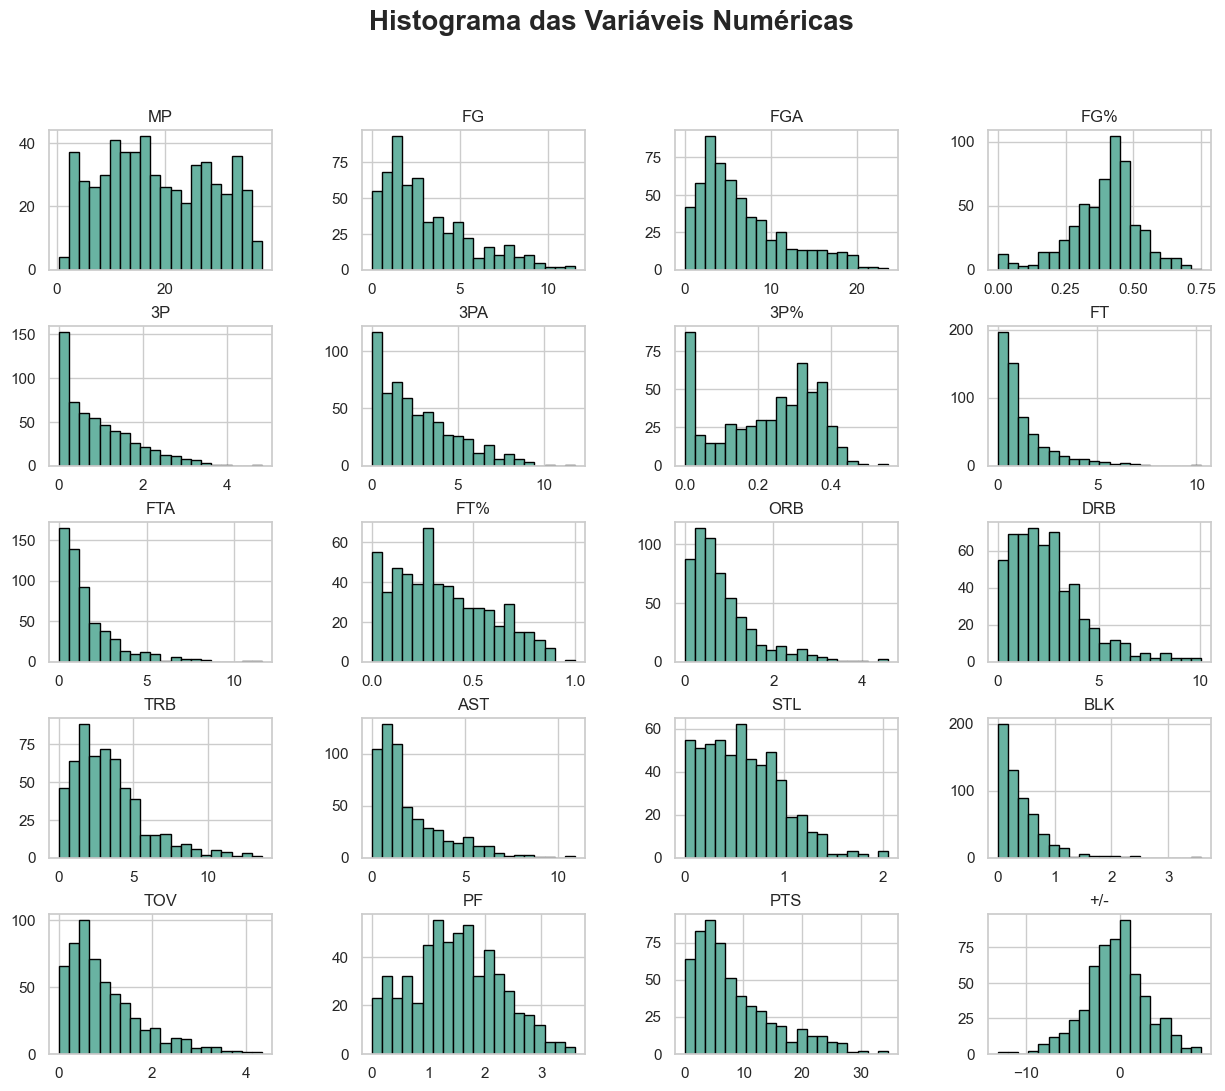

In [17]:
# Definir o estilo do gráfico usando Seaborn
sns.set(style="whitegrid")

# Gerar histogramas para todas as colunas numéricas do DataFrame
df.hist(figsize=(15, 12), bins=20, edgecolor='black', color='#69b3a2')  # Cor personalizada e bordas mais visíveis

# Adicionar títulos e rótulos
plt.suptitle('Histograma das Variáveis Numéricas', fontsize=20, fontweight='bold')
plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Ajustar o espaçamento entre os subgráficos

# Adicionar rótulos aos eixos
for ax in plt.gcf().axes:
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)

plt.show()

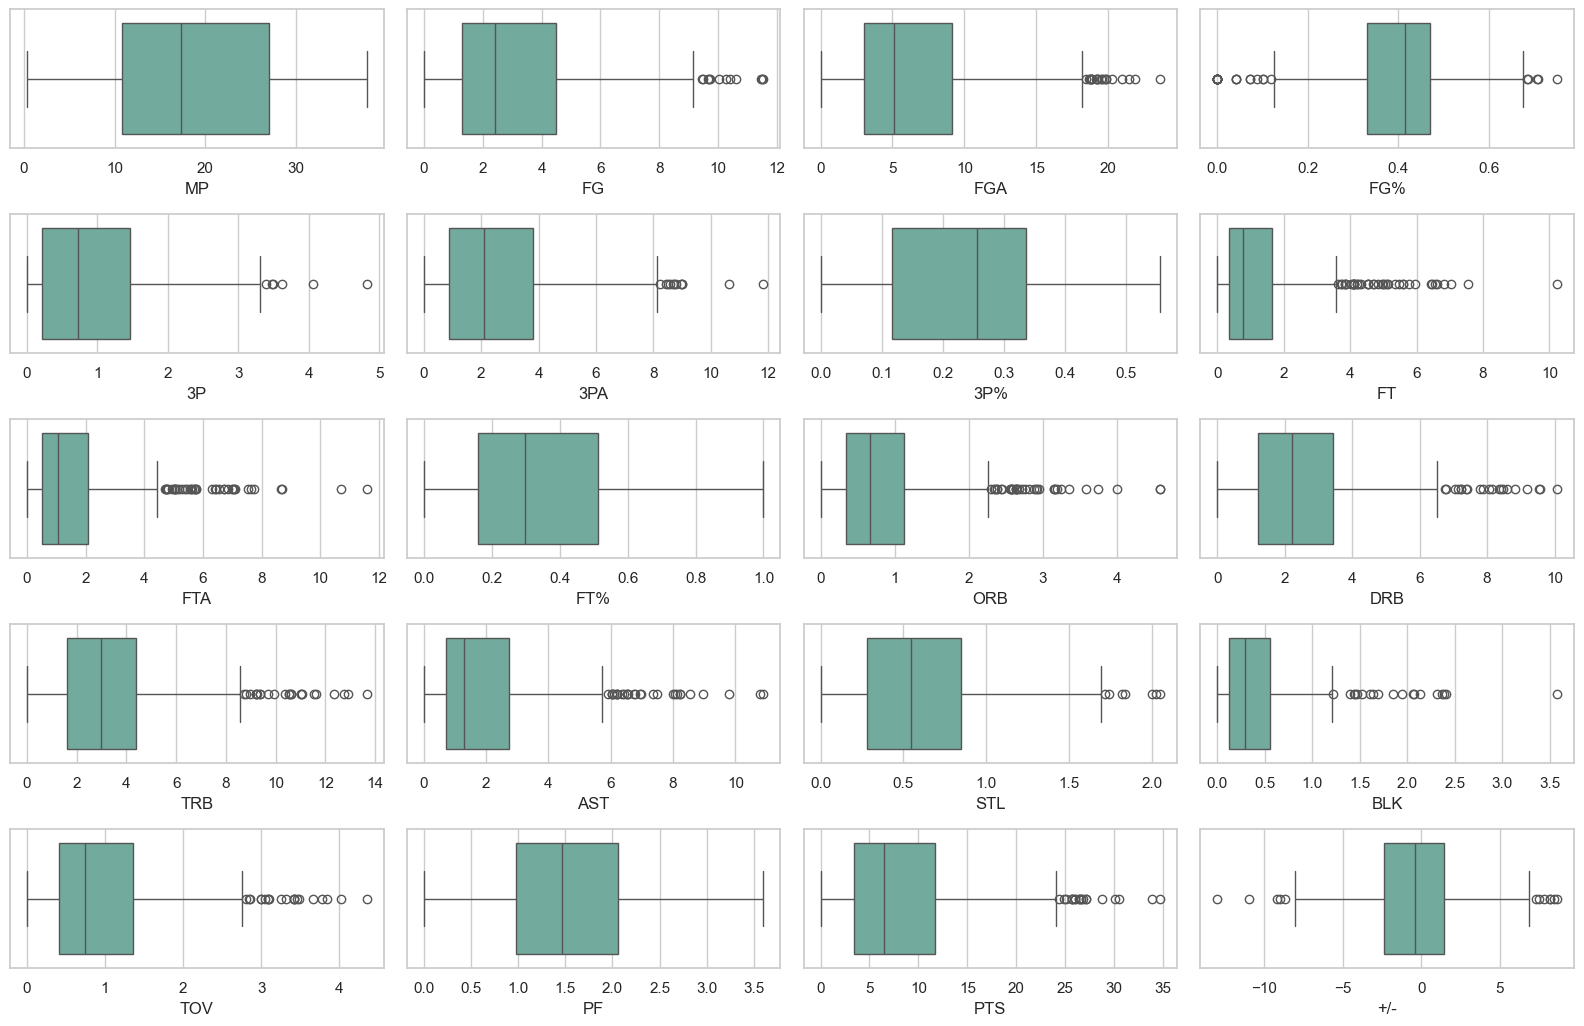

In [18]:
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# Criação dos boxplots para todas as variáveis numéricas
plt.figure(figsize=(16, 12))
for i, column in enumerate(df_numeric.columns, 1):
    plt.subplot(len(df_numeric.columns) // 4 + 1, 4, i)  # Organiza os boxplots em múltiplas linhas/colunas
    sns.boxplot(x=df_numeric[column], color='#69b3a2')
    plt.tight_layout()

plt.show()

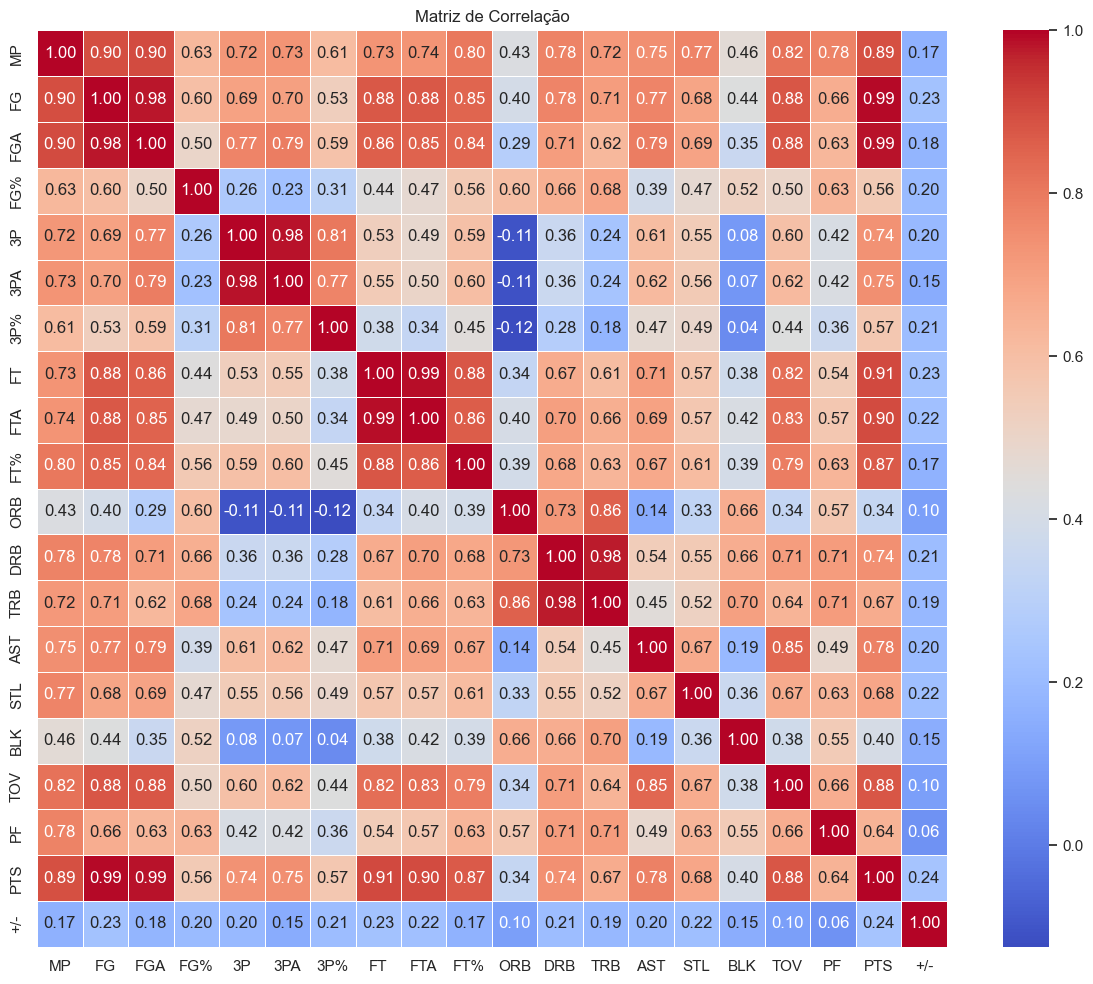

In [19]:
# Calcular a matriz de correlação
corr = df_numeric.corr()

# Criar o heatmap de correlação
plt.figure(figsize=(12, 10))  # Tamanho da figura
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, edgecolor='black')

# Adicionar título e ajustar o layout
plt.title('Matriz de Correlação')
plt.tight_layout()

plt.show()

### Feature engineering

In [20]:
# Criação de novas variáveis no df com todos os jogos
df_total['Home_Game'] = df_total['vs'].notna().astype(int)

# Conta o número de jogos em casa no df_total para cada jogador
home_games_count = df_total[df_total['Home_Game'] == 1].groupby('Player').size().reset_index(name='Home_Games_Count')
df = df.merge(home_games_count, on='Player', how='left')
df['Home_Games_Count'] = df['Home_Games_Count'].fillna(0).astype(int) # Substitui valores NaN por 0 caso algum jogador do df não tenha jogos em casa no df_total

# Conta o número de jogos fora no df_total para cada jogador
away_games_count = df_total[df_total['Home_Game'] == 0].groupby('Player').size().reset_index(name='Away_Games_Count')
df = df.merge(away_games_count, on='Player', how='left')
df['Away_Games_Count'] = df['Away_Games_Count'].fillna(0).astype(int)

# Filtra jogos em casa e com vitória no df_total
home_wins_count = df_total[(df_total['Home_Game'] == 1) & (df_total['W/L'] == 'W')].groupby('Player').size().reset_index(name='Home_Wins_Count')
df = df.merge(home_wins_count, on='Player', how='left')
df['Home_Wins_Count'] = df['Home_Wins_Count'].fillna(0).astype(int)

# Calcula o número de derrotas em casa
df['Home_Losses_Count'] = df['Home_Games_Count'] - df['Home_Wins_Count']

# Identifica o adversário contra o qual o jogador marcou mais pontos
top_opponent = df_total.groupby(['Player', 'Opp'])['PTS'].sum().reset_index()
top_opponent = top_opponent.loc[top_opponent.groupby('Player')['PTS'].idxmax()] # Para cada jogador, identifica o adversário com o maior total de pontos
top_opponent = top_opponent.rename(columns={'Opp': 'Top_Opponent', 'PTS': 'Points_vs_Top_Opponent'})
df = df.merge(top_opponent[['Player', 'Top_Opponent', 'Points_vs_Top_Opponent']], on='Player', how='left')

# Identifica o adversário contra o qual o jogador conseguiu mais ressaltos
top_rebound_opponent = df_total.groupby(['Player', 'Opp'])['TRB'].sum().reset_index()
top_rebound_opponent = top_rebound_opponent.loc[top_rebound_opponent.groupby('Player')['TRB'].idxmax()]
top_rebound_opponent = top_rebound_opponent.rename(columns={'Opp': 'Top_Rebound_Opponent', 'TRB': 'Rebounds_vs_Top_Opponent'})
df = df.merge(top_rebound_opponent[['Player', 'Top_Rebound_Opponent', 'Rebounds_vs_Top_Opponent']], on='Player', how='left')

# Identifica o adversário contra o qual o jogador fez mais assistências
top_assist_opponent = df_total.groupby(['Player', 'Opp'])['AST'].sum().reset_index()
top_assist_opponent = top_assist_opponent.loc[top_assist_opponent.groupby('Player')['AST'].idxmax()]
top_assist_opponent = top_assist_opponent.rename(columns={'Opp': 'Top_Assist_Opponent', 'AST': 'Assists_vs_Top_Opponent'})
df = df.merge(top_assist_opponent[['Player', 'Top_Assist_Opponent', 'Assists_vs_Top_Opponent']], on='Player', how='left')

In [21]:
df_total

,Player,Tm,vs,Opp,W/L,MP,FG,FGA,FG%,3P,...,TRB,AST,STL,BLK,TOV,PF,PTS,+/-,Date,Home_Game
0,Devin Booker,PHO,@,NOP,W,39.366667,19,28,0.679,8,...,3,9,0,1,3,3,52,8.0,2024-04-01,1
1,Jaren Jackson,MEM,@,DET,W,34.383333,13,23,0.565,2,...,7,3,3,2,3,2,40,-13.0,2024-04-01,1
2,Tyrese Haliburton,IND,NaN,BRK,W,26.716667,9,15,0.600,4,...,4,13,1,1,0,1,27,26.0,2024-04-01,0
3,Cade Cunningham,DET,NaN,MEM,L,34.033333,13,22,0.591,3,...,4,8,2,1,4,1,36,6.0,2024-04-01,0
4,Dalano Banton,POR,@,ORL,L,35.383333,8,17,0.471,4,...,5,5,3,2,1,1,26,1.0,2024-04-01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26421,Julian Champagnie,SAS,@,PHO,W,3.050000,0,1,0.000,0,...,0,0,0,0,0,0,0,-1.0,2023-10-31,1
26422,DaQuan Jeffries,NYK,@,CLE,W,4.150000,0,1,0.000,0,...,0,0,0,0,0,1,0,-5.0,2023-10-31,1
26423,Malaki Branham,SAS,@,PHO,W,8.983333,1,7,0.143,1,...,0,0,1,0,1,0,3,2.0,2023-10-31,1
26424,Amir Coffey,LAC,NaN,ORL,W,10.266667,0,1,0.000,0,...,0,0,0,0,1,1,0,-4.0,2023-10-31,0


In [22]:
df

,Player,MP,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,...,Home_Games_Count,Away_Games_Count,Home_Wins_Count,Home_Losses_Count,Top_Opponent,Points_vs_Top_Opponent,Top_Rebound_Opponent,Rebounds_vs_Top_Opponent,Top_Assist_Opponent,Assists_vs_Top_Opponent
0,A.J. Green,10.968155,1.482143,3.500000,0.359804,1.232143,3.017857,0.319875,0.303571,0.339286,...,23,33,11,12,MIN,27,CHI,7,CHI,4
1,A.J. Lawson,7.400397,1.285714,2.880952,0.381024,0.309524,1.190476,0.117357,0.357143,0.547619,...,19,23,14,5,OKC,29,SAS,9,OKC,4
2,AJ Griffin,8.535000,0.900000,3.100000,0.305950,0.500000,1.950000,0.241650,0.100000,0.100000,...,11,9,4,7,IND,13,BOS,4,MIN,2
3,Aaron Gordon,31.462785,5.452055,9.808219,0.579055,0.547945,1.890411,0.215726,2.424658,3.684932,...,38,35,21,17,GSW,77,GSW,36,POR,19
4,Aaron Holiday,16.270513,2.384615,5.346154,0.384462,1.076923,2.782051,0.315244,0.743590,0.807692,...,40,38,14,26,POR,47,DAL,12,LAL,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Zach LaVine,34.874000,6.800000,15.040000,0.433160,2.360000,6.760000,0.323200,3.520000,4.120000,...,12,13,4,8,DET,70,BRK,13,MIA,11
568,Zavier Simpson,23.054762,2.428571,7.714286,0.275286,0.714286,2.428571,0.154714,0.428571,0.571429,...,2,5,0,2,PHI,14,CLE,8,SAS,5
569,Zeke Nnaji,9.931609,1.189655,2.568966,0.387828,0.103448,0.396552,0.091948,0.724138,1.068966,...,30,28,17,13,DAL,22,LAC,10,GSW,4
570,Ziaire Williams,20.345752,2.941176,7.411765,0.343961,1.137255,3.705882,0.290431,1.215686,1.470588,...,26,25,13,13,POR,37,POR,24,HOU,7


### Análise de componentes principais

In [23]:
df_numeric = df.select_dtypes(include=['float64', 'int64'])
df_numeric.isna().sum()

MP                          0
FG                          0
FGA                         0
FG%                         0
3P                          0
3PA                         0
3P%                         0
FT                          0
FTA                         0
FT%                         0
ORB                         0
DRB                         0
TRB                         0
AST                         0
STL                         0
BLK                         0
TOV                         0
PF                          0
PTS                         0
+/-                         0
Home_Games_Count            0
Away_Games_Count            0
Home_Wins_Count             0
Home_Losses_Count           0
Points_vs_Top_Opponent      0
Rebounds_vs_Top_Opponent    0
Assists_vs_Top_Opponent     0
dtype: int64

In [24]:
# Padroniza as colunas numéricas
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_numeric)

# Aplica a PCA com o número de componentes igual ao número de colunas
pca = PCA(n_components=df_numeric.shape[1])  # Número de componentes igual ao número de colunas
pca.fit(scaled_data)

# Obtém a variância explicada por cada componente
explained_variance = pca.explained_variance_ratio_

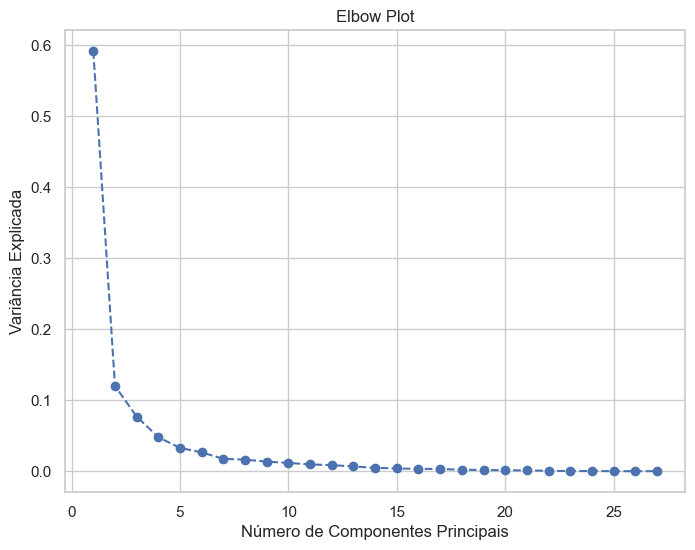

In [25]:
# Plot do gráfico "elbow" para visualizar a variância explicada
plt.figure(figsize=(8,6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Elbow Plot')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada')
plt.grid(True)
plt.show()

[0.59120667 0.71108982 0.78795948 0.83571409 0.86846943 0.89490583
 0.91225801 0.92845809 0.94191733 0.95358682 0.96304711 0.97156241
 0.97816162 0.98285592 0.98671807 0.98995444 0.99308722 0.99505398
 0.99671565 0.99804071 0.99915038 0.99966606 0.99988504 1.
 1.         1.         1.        ]


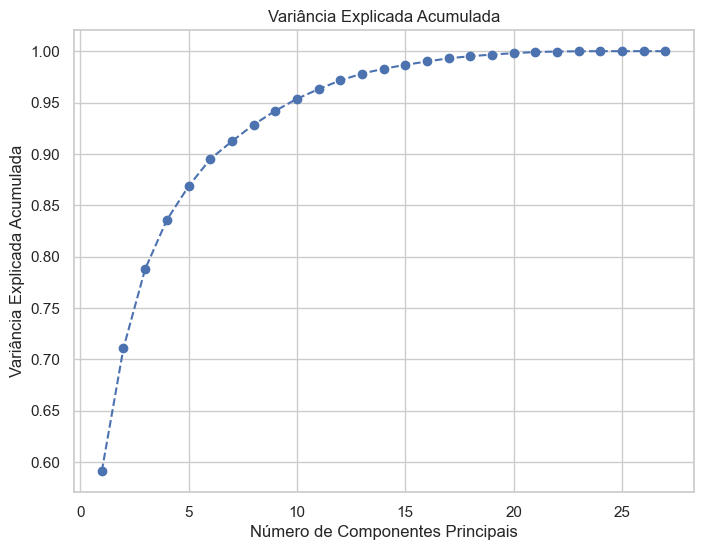

In [26]:
cumulative_variance = explained_variance.cumsum()

# Exibe a % de variância explicada acumulada
print(cumulative_variance)

# Plota a variância explicada acumulada
plt.figure(figsize=(8,6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Variância Explicada Acumulada')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada Acumulada')
plt.grid(True)
plt.show()

In [27]:
eigenvalues = pca.explained_variance_

# Aplica o critério de Kaiser: selecionar componentes com eigenvalue > 1
n_components_kaiser = sum(eigenvalues > 1)
print(f"Número de componentes com eigenvalue > 1: {n_components_kaiser}")

Número de componentes com eigenvalue > 1: 4


In [28]:
eigenvalues

array([1.59905356e+01, 3.24251380e+00, 2.07911556e+00, 1.29163261e+00,
       8.85943053e-01, 7.15032916e-01, 4.69329183e-01, 4.38168143e-01,
       3.64036110e-01, 3.15627914e-01, 2.55875246e-01, 2.30315596e-01,
       1.78490772e-01, 1.26968002e-01, 1.04460876e-01, 8.75349787e-02,
       8.47332390e-02, 5.31953943e-02, 4.49437302e-02, 3.58393444e-02,
       3.00135874e-02, 1.39475781e-02, 5.92282755e-03, 3.10938983e-03,
       5.91449243e-16, 1.97230442e-16, 0.00000000e+00])

In [29]:
# Aplica PCA com 5 componentes principais
pca = PCA(n_components=5)
X_pca = pca.fit_transform(scaled_data)

# Cargas das componentes principais
loadings = pca.components_

# Cria um DataFrame para as cargas
df_loadings = pd.DataFrame(loadings, columns=df_numeric.columns, index=[f'PC{i+1}' for i in range(5)])

In [30]:
df_loadings.T

,PC1,PC2,PC3,PC4,PC5
MP,0.237500,-0.024941,0.008273,-0.090479,0.152159
FG,0.237611,-0.040970,-0.139871,0.014682,0.007537
FGA,0.233340,-0.116052,-0.142990,-0.035092,0.033698
FG%,0.168257,0.214695,0.135566,-0.002284,0.091232
3P,0.175349,-0.328508,0.060247,-0.027852,0.323105
3PA,0.175259,-0.330925,0.026042,-0.068662,0.301402
3P%,0.146396,-0.290194,0.189745,-0.019814,0.386205
FT,0.209942,-0.034696,-0.268919,0.077303,-0.192777
FTA,0.210979,0.009648,-0.268575,0.072136,-0.204015
FT%,0.217862,-0.018270,-0.136143,-0.031986,-0.094449


## Caracterização das Componentes Principais (PCs)

### **PC1 (Componente Principal 1)**:
- **Principais variáveis**: MP, FG, FGA, 3P, 3PA, FT, FTA, PTS.
- **Interpretação**: A PC1 está fortemente relacionada com a produção ofensiva de um jogador. Variáveis como `MP` (minutos jogados), `FG` (arremessos convertidos), `FGA` (arremessos tentados), `3P` (três pontos convertidos), `PTS` (pontos) indicam que esta componente captura a eficiência e o volume de jogo ofensivo. Em resumo, **a PC1 representa a eficiência e volume ofensivo** de um jogador.

### **PC2 (Componente Principal 2)**:
- **Principais variáveis**: ORB, DRB, TRB, BLK.
- **Interpretação**: A PC2 está fortemente correlacionada com o jogo defensivo e os ressaltos. As variáveis como `ORB` (ressaltos ofensivos), `DRB` (ressaltos defensivos) e `BLK` (bloqueios) indicam que esta componente captura o impacto defensivo de um jogador e a sua capacidade de controlar o jogo no garrafão. **A PC2 representa a capacidade de ressaltos e defesa**.

### **PC3 (Componente Principal 3)**:
- **Principais variáveis**: Home_Games_Count, Away_Games_Count, Home_Wins_Count, Home_Losses_Count.
- **Interpretação**: A PC3 está relacionada com o desempenho em jogos em casa e fora de casa. A presença de variáveis como `Home_Games_Count` (número de jogos em casa), `Away_Games_Count` (jogos fora), `Home_Wins_Count` (vitórias em casa) e `Home_Losses_Count` (derrotas em casa) sugere que este componente pode estar a capturar o impacto das condições de jogo (casa vs. fora) no desempenho. **A PC3 representa a performance em jogos em casa e fora de casa**.

### **PC4 (Componente Principal 4)**:
- **Principais variáveis**: +/- (diferencial de pontos), Home_Wins_Count, Home_Losses_Count.
- **Interpretação**: A PC4 parece capturar o impacto global no jogo, visto que está associada a `+/-` (diferencial de pontos) e ao desempenho em casa (`Home_Wins_Count` e `Home_Losses_Count`). A variável `+/-` mede a diferença de pontos enquanto o jogador está em campo, sendo uma medida do impacto global do jogador na partida. **A PC4 representa o impacto geral no jogo** (diferencial de pontos e desempenho em casa).

### **PC5 (Componente Principal 5)**:
- **Principais variáveis**: 3P%, 3PA, FT%, Assists_vs_Top_Opponent.
- **Interpretação**: A PC5 parece ser uma combinação de precisão no arremesso de três pontos e na linha de lance livre, juntamente com a performance nas assistências contra adversários fortes. As variáveis `3P%`, `FT%` e `Assists_vs_Top_Opponent` indicam que esta componente está relacionada com a **eficiência no ataque e a habilidade de criar jogadas** contra adversários difíceis.

---

## Resumo das Componentes Principais:

1. **PC1**: Eficácia ofensiva (minutos jogados, arremessos, pontos).
2. **PC2**: Jogo defensivo e controlo de ressaltos (ressaltos ofensivos, defensivos, bloqueios).
3. **PC3**: Performance em jogos em casa vs. fora de casa (jogos em casa, vitórias e derrotas em casa).
4. **PC4**: Impacto geral no jogo (diferencial de pontos e desempenho em casa).
5. **PC5**: Eficiência nos arremessos e assistências contra adversários difíceis (arremessos de três, lance livre).


### K means

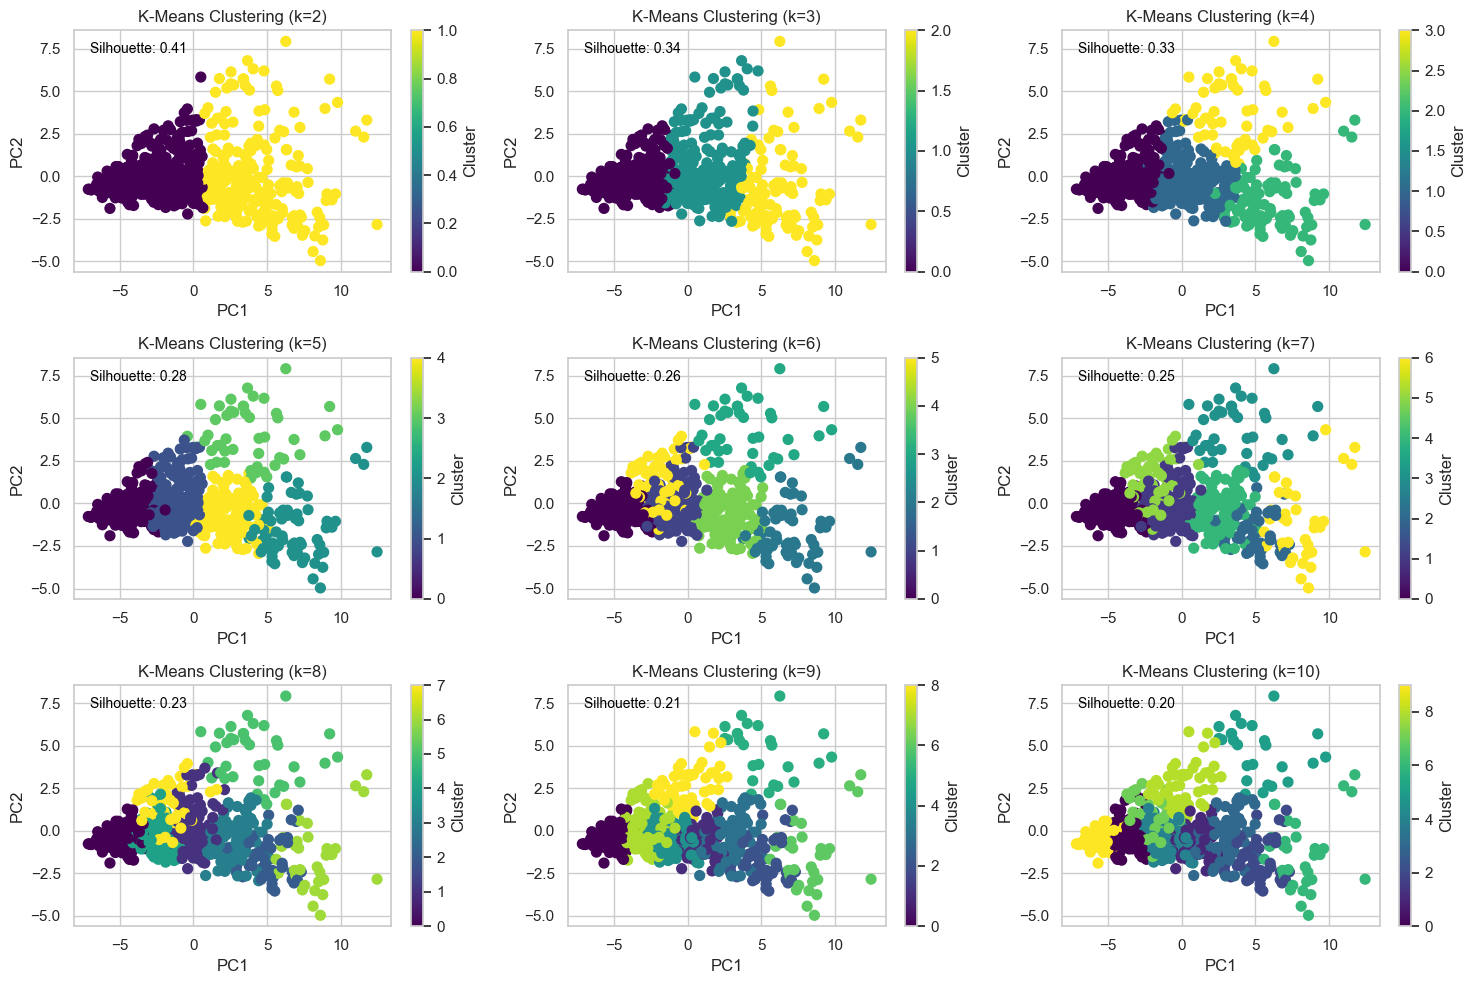

In [31]:
# Adicionar as componentes principais ao DataFrame
df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']] = X_pca
# Selecionar apenas as PCs para o clustering
df_pcs = df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']]

# Testar para diferentes valores de k (número de clusters)
k_range = range(2, 11)  # testar de 2 a 10 clusters 
silhouette_scores = []

# Criar os gráficos para cada valor de k
plt.figure(figsize=(15, 10))

for k in k_range:
    # Aplicar o K-Means para os dados das componentes principais
    kmeans = KMeans(n_clusters=k, random_state=42)
    df['Cluster'] = kmeans.fit_predict(df_pcs)

    # Calcular o Silhouette Score para o valor de k
    silhouette_avg = silhouette_score(df_pcs, df['Cluster'])
    silhouette_scores.append(silhouette_avg)

    # Visualizar os clusters em um gráfico 2D (PC1 vs PC2)
    plt.subplot(3, 3, k-1)  # organiza os gráficos em 3x3
    plt.scatter(df['PC1'], df['PC2'], c=df['Cluster'], cmap='viridis', s=50)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(f'K-Means Clustering (k={k})')
    plt.colorbar(label='Cluster')

    # Exibir o Silhouette Score no gráfico
    plt.text(0.05, 0.95, f'Silhouette: {silhouette_avg:.2f}', fontsize=10, color='black',
             transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

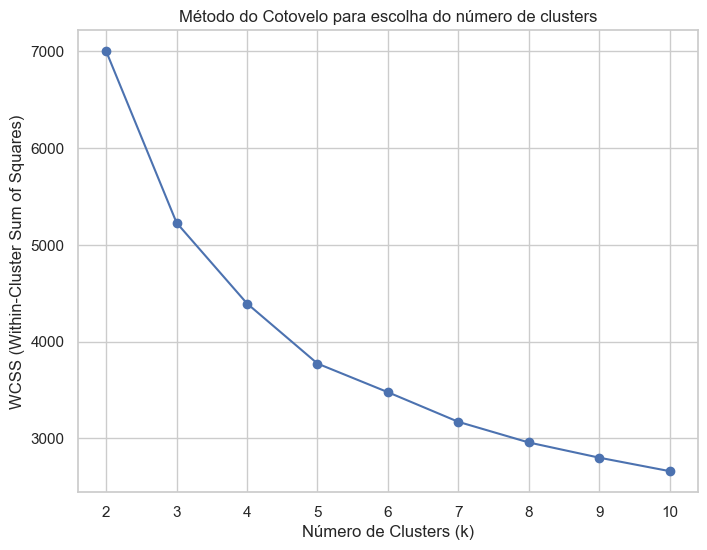

In [32]:
wcss = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pcs)
    wcss.append(kmeans.inertia_)  

# Plot
plt.figure(figsize=(8, 6))
plt.plot(k_range, wcss, marker='o', color='b')
plt.title('Método do Cotovelo para escolha do número de clusters')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()


Silhouette Score for k=5: 0.2779


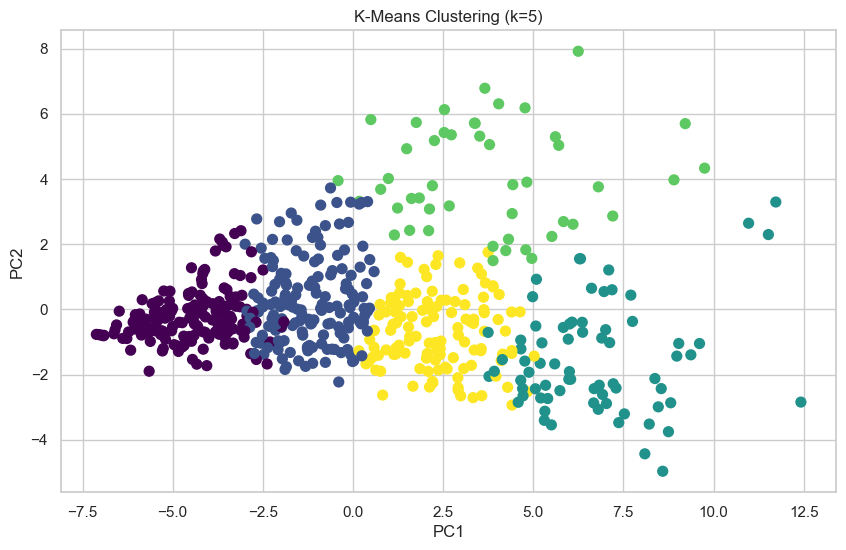

  Cluster       PC1                 PC2                 PC3            \
               mean       std      mean       std      mean       std   
0       0 -4.426167  1.153885 -0.223890  0.798422 -0.831290  0.814728   
1       1 -1.189655  0.967506  0.251073  1.317152  0.753825  1.119234   
2       2  6.676299  1.886063 -1.507369  1.653591 -1.467400  1.428421   
3       3  3.723627  2.351701  4.032753  1.580047 -0.106373  1.283739   
4       4  2.365554  1.185734 -0.695011  1.115014  1.060057  1.122132   

        PC4                 PC5            
       mean       std      mean       std  
0  0.248416  0.830596 -0.043115  0.718702  
1 -0.209911  0.903461 -0.075773  0.851784  
2  0.109770  1.751144 -0.466739  1.134685  
3 -0.058820  1.219074  0.243076  1.143480  
4 -0.106658  1.235878  0.345604  0.982490  


In [33]:
# Aplicar KMeans com 5 clusters pela análise gráfica + elbow
kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_pcs)

# Silhouette Score para k=5
silhouette_avg = silhouette_score(df_pcs, df['Cluster'])
print(f"Silhouette Score for k=5: {silhouette_avg:.4f}")

# Visualizar os clusters 2D (PC1 vs PC2) para melhor interpretação
plt.figure(figsize=(10, 6))
plt.scatter(df['PC1'], df['PC2'], c=df['Cluster'], cmap='viridis', s=50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clustering (k=5)')
plt.show()

# Caracterizar os clusters: Calcular a média e o std para cada componente principal por cluster
cluster_summary_pcas = df.groupby('Cluster').agg({
    'PC1': ['mean', 'std'],
    'PC2': ['mean', 'std'],
    'PC3': ['mean', 'std'],
    'PC4': ['mean', 'std'],
    'PC5': ['mean', 'std']
}).reset_index()

print(cluster_summary_pcas)

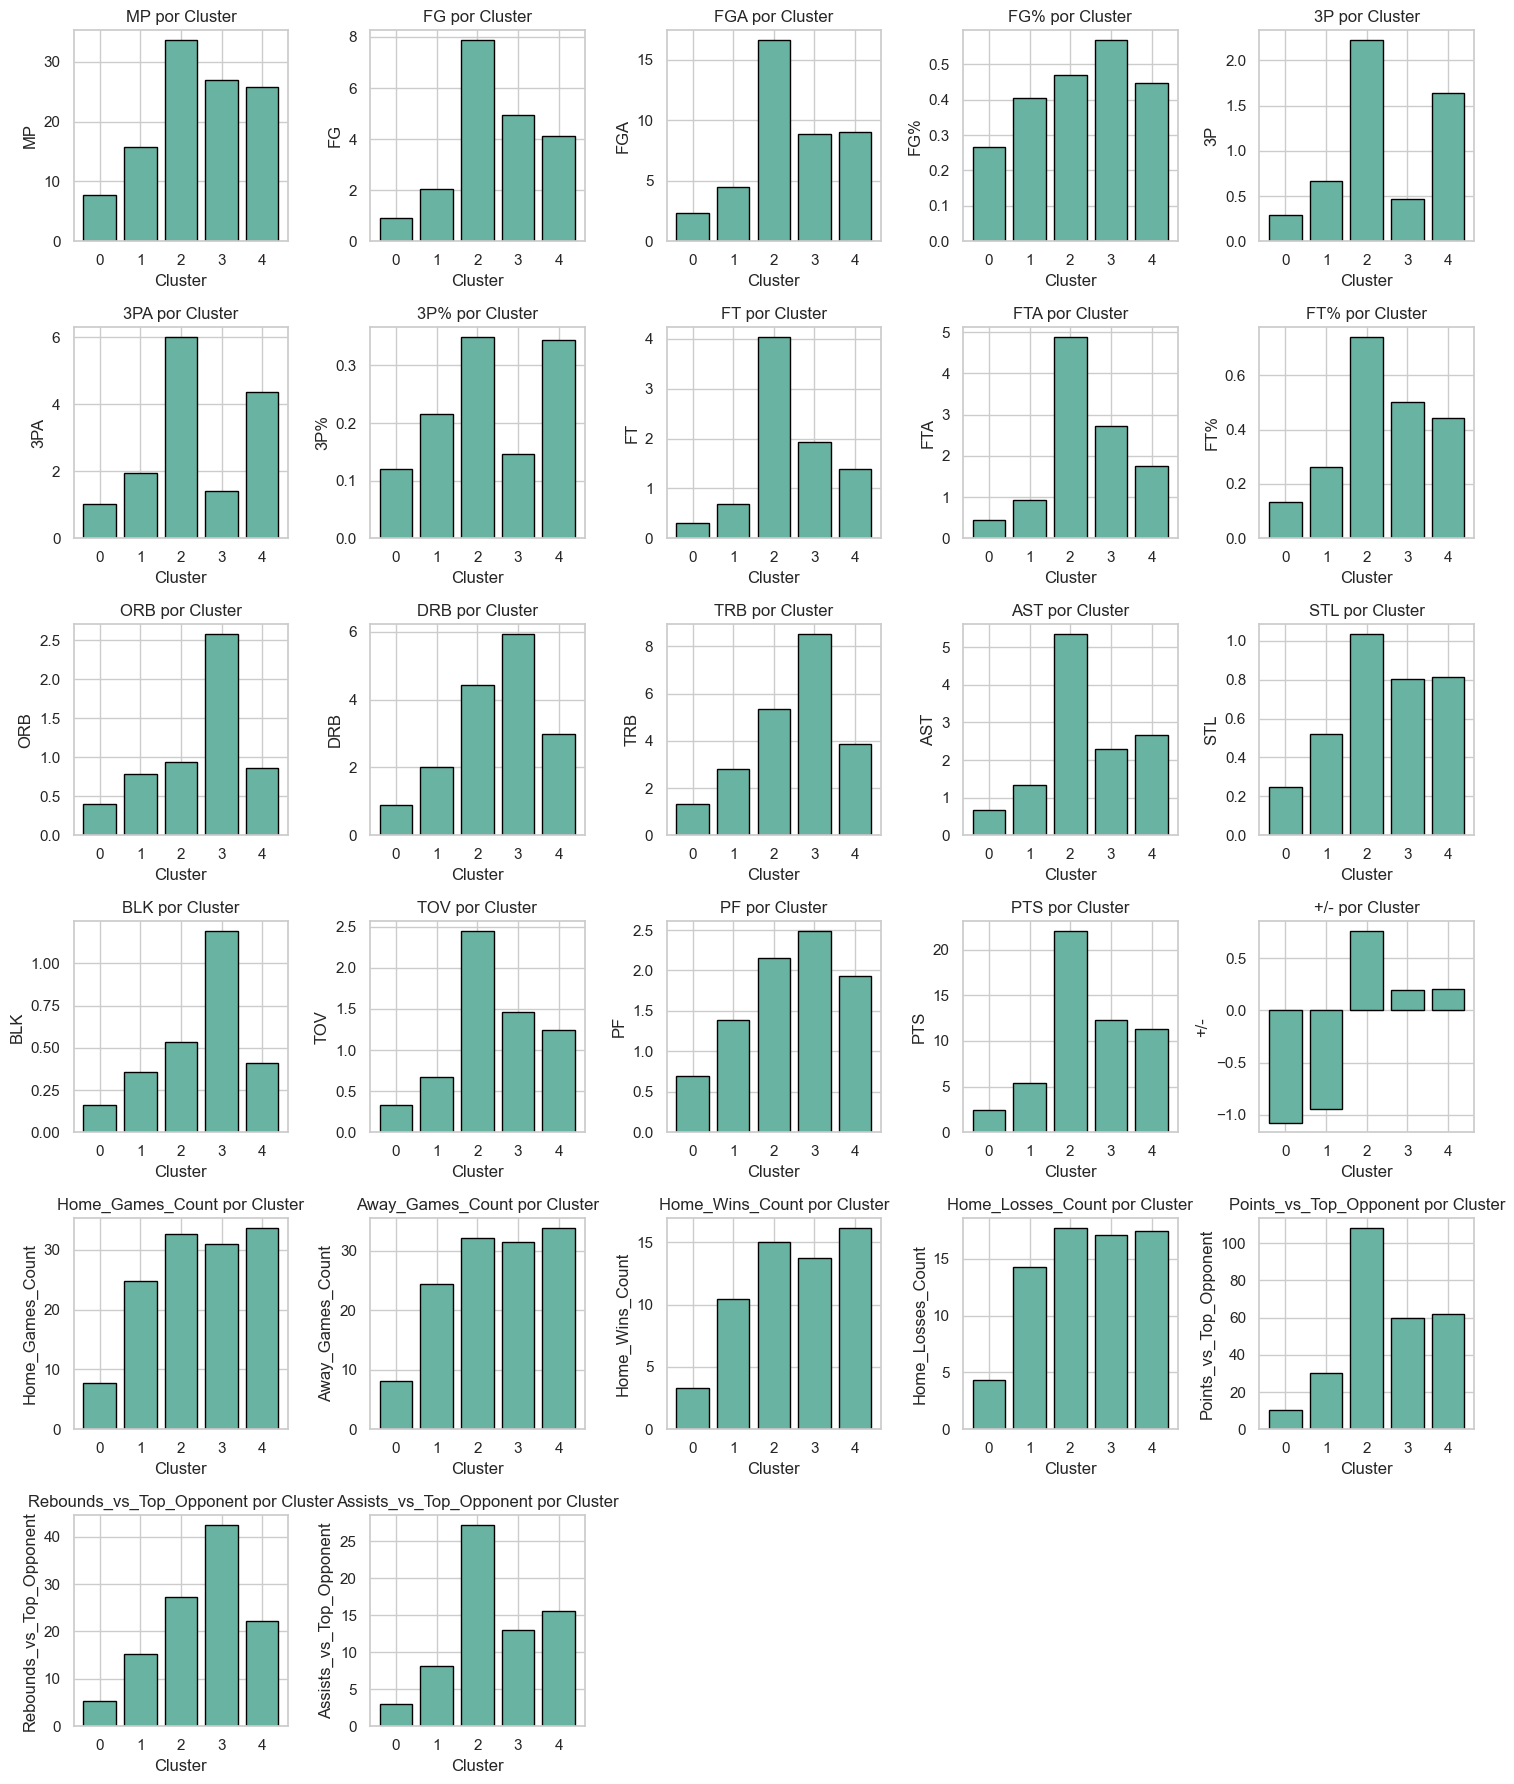

In [34]:
# Lista de variáveis para "plotar"
variables = [
    'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%',
    'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
    '+/-', 'Home_Games_Count', 'Away_Games_Count', 'Home_Wins_Count',
    'Home_Losses_Count', 'Points_vs_Top_Opponent', 'Rebounds_vs_Top_Opponent',
    'Assists_vs_Top_Opponent'
]

# Criar um DataFrame com as médias por cluster para essas variáveis
cluster_summary = df.groupby('Cluster')[variables].mean().reset_index()

# Número de linhas e colunas para a grid de gráficos
n_cols = 5
n_rows = int(np.ceil(len(variables) / n_cols))  # Número de linhas baseado no número de variáveis

# Criar a grid de gráficos
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))

# Ajustar a grid caso tenhamos menos de 5 gráficos na última linha
axes = axes.flatten()

for i, var in enumerate(variables):
    ax = axes[i]
    ax.bar(cluster_summary['Cluster'], cluster_summary[var], edgecolor='black', color='#69b3a2')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(f'{var}')
    ax.set_title(f'{var} por Cluster')
    ax.set_xticks(cluster_summary['Cluster'])  # Para mostrar os clusters no eixo X

# Remover os eixos não utilizados
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [35]:
cluster_summary

,Cluster,MP,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,...,PF,PTS,+/-,Home_Games_Count,Away_Games_Count,Home_Wins_Count,Home_Losses_Count,Points_vs_Top_Opponent,Rebounds_vs_Top_Opponent,Assists_vs_Top_Opponent
0,0,7.745401,0.912700,2.314309,0.266537,0.285039,1.014456,0.120992,0.308351,0.441066,...,0.700246,2.418789,-1.074307,7.650888,8.071006,3.301775,4.349112,10.562130,5.295858,2.958580
1,1,15.694463,2.027414,4.448186,0.404981,0.671811,1.935886,0.215175,0.680787,0.924838,...,1.392231,5.407428,-0.939329,24.693252,24.509202,10.447853,14.245399,30.404908,15.202454,8.177914
2,2,33.558449,7.863361,16.605141,0.468489,2.221418,5.992980,0.348524,4.027481,4.870603,...,2.157889,21.975622,0.758410,32.666667,32.236111,15.000000,17.666667,107.847222,27.166667,27.166667
3,3,26.913575,4.960464,8.875210,0.567515,0.463966,1.405961,0.146243,1.927200,2.723816,...,2.482685,12.312094,0.193732,30.893617,31.446809,13.765957,17.127660,59.680851,42.361702,13.063830
4,4,25.747780,4.122032,9.015734,0.446229,1.642142,4.366682,0.343988,1.391855,1.757248,...,1.934189,11.278061,0.204779,33.553719,33.768595,16.123967,17.429752,61.842975,22.132231,15.586777


# Caracterização dos Clusters

### **Cluster 0: "Jogadores Menos Ativos/Inicio ou fim de carreira"**
- **Atividade**: Baixa média de minutos por jogo (7.75), com estatísticas bem abaixo da média.
- **Ofensiva**: Menor envolvimento ofensivo, com poucos pontos, assistências e lançamentos.
- **Defesa**: Contribuição limitada em ressaltos e bloqueios.
- **Desempenho**: Baixa pontuação e percentagens de lançamento (FG% de 26.7%).

### **Cluster 1: "Jogadores de Papel Secundário/Bench players"**
- **Atividade**: Média de 15.69 minutos por jogo.
- **Ofensiva**: Baixo volume ofensivo. Apenas 5.41 pontos de média.
- **Defesa**: Contribuem razoavelmente em ressaltos (com mais destaque para ressaltos defensivos) e assistências.

### **Cluster 2: "Jogadores Estrela"**
- **Atividade**: Muito ativos com média de 33.56 minutos por jogo.
- **Ofensiva**: Grande destaque em pontos (21.98), assistências e boa percentagem de lançamento (FG% de 46.8%).
- **Defesa**: Forte em ressaltos, com bom desempenho nas duas extremidades do jogo.

### **Cluster 3: "Defensive role players"**
- **Atividade**: Média de 26.91 minutos, com bom desempenho equilibrado.
- **Ofensiva**: Boa produção de pontos e ressaltos.
- **Defesa**: Boa contribuição defensiva, especialmente em ressaltos.

### **Cluster 4: "Role players ofensivos"**
- **Atividade**: Média de 25.75 minutos, com bom desempenho ofensivo e defensivo.
- **Ofensiva**: Boa produção em pontos (11.28) e lançamentos.
- **Defesa**: Contribuição sólida em ressaltos e assistências.

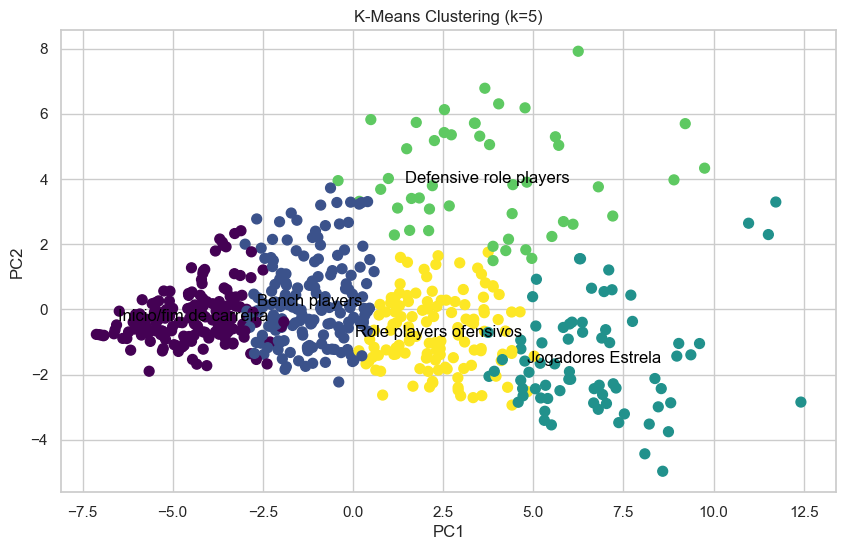

In [36]:
# Definir os nomes dos clusters
cluster_names = {
    0: "Inicio/fim de carreira",
    1: "Bench players",
    2: "Jogadores Estrela",
    3: "Defensive role players",
    4: "Role players ofensivos"
}

# Visualizar os clusters 2D (PC1 vs PC2) para melhor interpretação
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['PC1'], df['PC2'], c=df['Cluster'], cmap='viridis', s=50)

# Adicionar nomes dos clusters no gráfico
for cluster_id in range(5):
    # Calcular a posição média dos pontos de cada cluster
    cluster_center = df[df['Cluster'] == cluster_id][['PC1', 'PC2']].mean()
    plt.text(cluster_center['PC1'], cluster_center['PC2'], cluster_names[cluster_id], fontsize=12, ha='center', va='center', color='black')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clustering (k=5)')
plt.show()

### Análise de equipas com mais jogadores por cluster

In [37]:
merged_df = df.merge(df_total[['Player', 'Tm']], on='Player', how='left')
merged_df = merged_df.drop_duplicates(subset='Player', keep='first')

# Contar as ocorrências de cada combinação Cluster + Tm
team_counts = merged_df.groupby(['Cluster', 'Tm']).size().reset_index(name='Num_Occurrences')

# Ordenar por Cluster e Num_Occurrences em ordem decrescente
team_counts = team_counts.sort_values(['Cluster', 'Num_Occurrences'], ascending=[True, False])

# Selecionar o top 3 por cluster
team_counts['Rank'] = team_counts.groupby('Cluster')['Num_Occurrences'].rank(method='first', ascending=False)
top_3_per_cluster = team_counts[team_counts['Rank'] <= 3].drop(columns='Rank').reset_index(drop=True)

In [38]:
top_3_per_cluster

,Cluster,Tm,Num_Occurrences
0,0,TOR,9
1,0,NOP,8
2,0,DAL,7
3,1,DET,10
4,1,MEM,9
5,1,CHO,8
6,2,POR,4
7,2,BOS,3
8,2,BRK,3
9,3,HOU,4


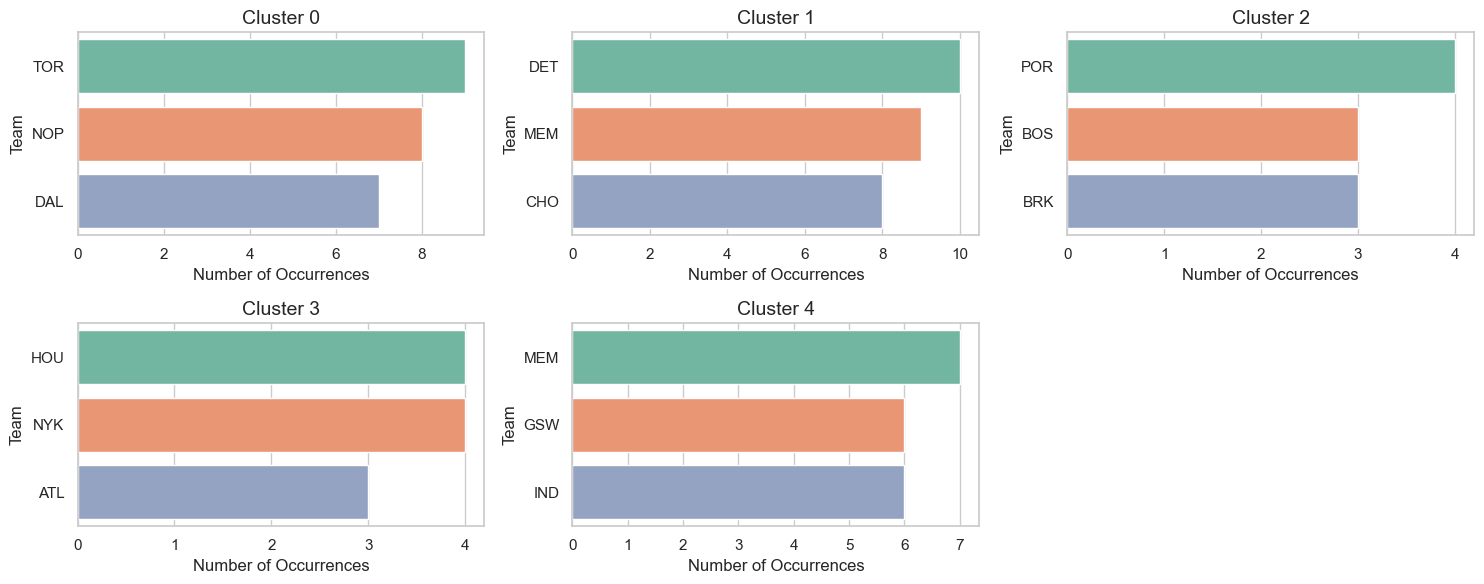

In [39]:
# Definir o número de clusters 
clusters = top_3_per_cluster['Cluster'].unique()
num_clusters = len(clusters)

# Definir o número de colunas para o layout
ncols = 3  
nrows = int(np.ceil(num_clusters / ncols))  # Calcula o número de linhas necessárias

# Criar os subgráficos com base no número de clusters
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 6))

# Ajustar a disposição das axes (caso seja um único gráfico, axes é um único objeto)
axes = axes.flatten()

# Plotar um gráfico para cada cluster
for i, cluster in enumerate(clusters):
    ax = axes[i]
    cluster_data = top_3_per_cluster[top_3_per_cluster['Cluster'] == cluster]
    sns.barplot(x='Num_Occurrences', y='Tm', data=cluster_data, ax=ax, palette='Set2', hue='Tm', legend=False)
    ax.set_title(f'Cluster {cluster}', fontsize=14)
    ax.set_xlabel('Number of Occurrences', fontsize=12)
    ax.set_ylabel('Team', fontsize=12)

# Descartar os eixos extras, caso haja algum gráfico vazio
for i in range(num_clusters, len(axes)):
    axes[i].axis('off')  # Remove o eixo vazio

# Ajustar o layout para não sobrepor os gráficos
plt.tight_layout()
plt.show()

In [40]:
merged_df[merged_df['Tm']=='POR'][['Player', 'PTS', 'TRB', 'BLK', 'STL', 'MP', '3P%','Cluster']]

,Player,PTS,TRB,BLK,STL,MP,3P%,Cluster
1272,Anfernee Simons,22.586957,3.630435,0.108696,0.500000,34.385507,0.360283,2
1603,Ashton Hagans,4.210526,2.368421,0.473684,0.578947,16.608772,0.157895,1
5289,Dalano Banton,10.314815,3.296296,0.370370,0.611111,19.386111,0.194796,4
6469,Deandre Ayton,16.727273,11.072727,0.763636,1.018182,32.427879,0.018182,3
7966,Duop Reath,9.073529,3.676471,0.558824,0.485294,17.853922,0.361515,4
9722,Ibou Badji,1.545455,2.318182,0.909091,0.136364,10.264394,0.000000,0
10506,Jabari Walker,8.861111,7.055556,0.305556,0.583333,23.617361,0.253278,3
12807,Jerami Grant,20.962963,3.537037,0.629630,0.833333,33.892593,0.390481,2
15000,Justin Minaya,1.794118,1.647059,0.294118,0.264706,11.204902,0.116647,0
16662,Kris Murray,6.064516,3.612903,0.338710,0.854839,21.744624,0.229903,1


In [41]:
merged_df[merged_df['Player']=='Damian Lillard'][['Player', 'PTS', 'TRB', 'BLK', 'STL', 'MP', 'Cluster']]

,Player,PTS,TRB,BLK,STL,MP,Cluster
5441,Damian Lillard,24.315068,4.383562,0.246575,0.986301,35.321918,2


### Cálculo da métrica de Score personalizada

#### Análise dos melhores jogadores por cluster tendo em conta o Score

In [42]:
# Calculo de métrica
df['Score'] = (2 * df['PTS'] + 2 * df['AST'] + 0.5 * df['TRB'] + 2 * df['BLK'] + 2 * df['STL'] - 2 * df['TOV'])/df['MP']

In [43]:
# Ordenar por Cluster e Score em ordem decrescente
player_counts = df[['Cluster', 'Player', 'Score']].sort_values(['Cluster', 'Score'], ascending=[True, False])
# Selecionar o top jogadores por cluster
top_players_per_cluster = player_counts.groupby('Cluster').head(10).reset_index(drop=True)

In [44]:
top_players_per_cluster

,Cluster,Player,Score
0,0,Markquis Nowell,3.127962
1,0,Izaiah Brockington,2.660099
2,0,Hamidou Diallo,1.894737
3,0,D.J. Wilson,1.875000
4,0,Luka Garza,1.802135
5,0,Dexter Dennis,1.757812
6,0,Ryan Rollins,1.701991
7,0,Oscar Tshiebwe,1.682785
8,0,Leonard Miller,1.679389
9,0,RaiQuan Gray,1.626815


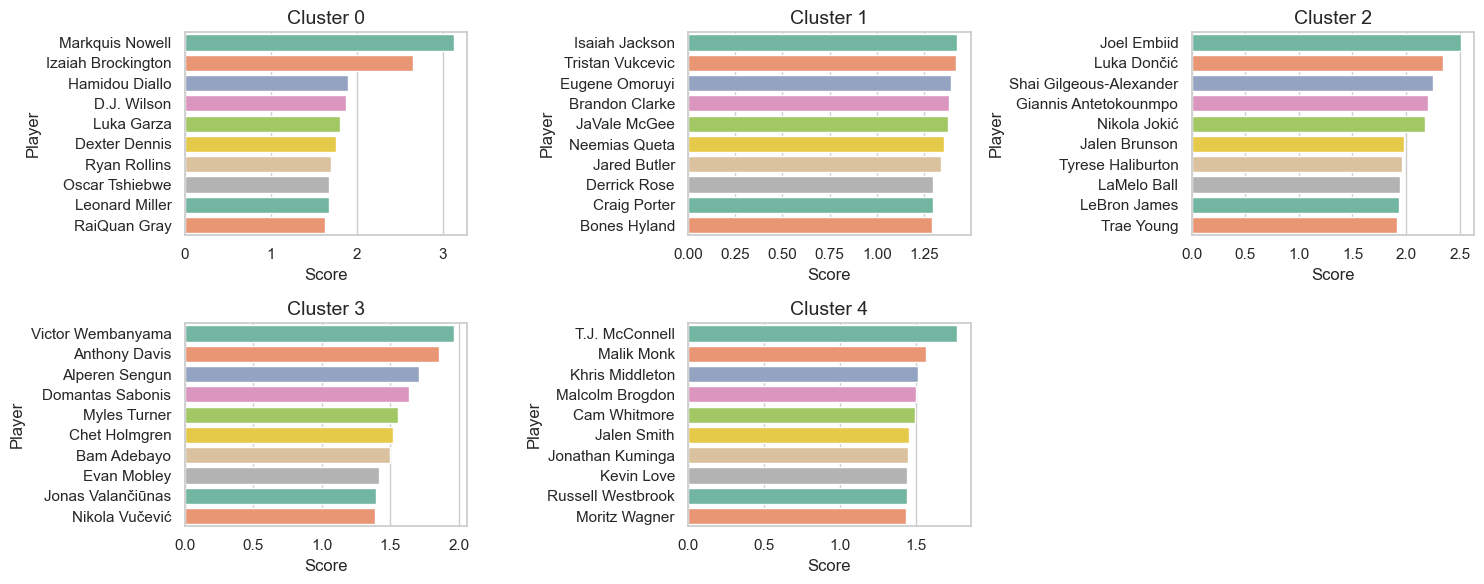

In [45]:
# Definir o número de clusters
clusters = top_players_per_cluster['Cluster'].unique()
num_clusters = len(clusters)

# Definir o número de colunas para o layout
ncols = 3 
nrows = int(np.ceil(num_clusters / ncols))  # Calcula o número de linhas necessárias

# Criar os subgráficos com base no número de clusters
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 6))

# Ajustar a disposição das axes (caso seja um único gráfico, axes é um único objeto)
axes = axes.flatten()

# Plotar um gráfico para cada cluster
for i, cluster in enumerate(clusters):
    ax = axes[i]
    cluster_data = top_players_per_cluster[top_players_per_cluster['Cluster'] == cluster]
    sns.barplot(x='Score', y='Player', data=cluster_data, ax=ax, hue='Player', palette='Set2')
    ax.set_title(f'Cluster {cluster}', fontsize=14)
    ax.set_xlabel('Score', fontsize=12)
    ax.set_ylabel('Player', fontsize=12)

# Descartar os eixos extras, caso haja algum gráfico vazio
for i in range(num_clusters, len(axes)):
    axes[i].axis('off')  # Remove o eixo vazio

# Ajustar o layout para não sobrepor os gráficos
plt.tight_layout()
plt.show()

C:\Users\joaop\AppData\Local\Temp\ipykernel_11452\1971880699.py:49: UserWarning: The palette list has more values (50) than needed (10), which may not be intended.
  sns.lineplot(
C:\Users\joaop\AppData\Local\Temp\ipykernel_11452\1971880699.py:49: UserWarning: The palette list has more values (50) than needed (10), which may not be intended.
  sns.lineplot(
C:\Users\joaop\AppData\Local\Temp\ipykernel_11452\1971880699.py:49: UserWarning: The palette list has more values (50) than needed (10), which may not be intended.
  sns.lineplot(
C:\Users\joaop\AppData\Local\Temp\ipykernel_11452\1971880699.py:49: UserWarning: The palette list has more values (50) than needed (10), which may not be intended.
  sns.lineplot(
C:\Users\joaop\AppData\Local\Temp\ipykernel_11452\1971880699.py:49: UserWarning: The palette list has more values (50) than needed (10), which may not be intended.
  sns.lineplot(


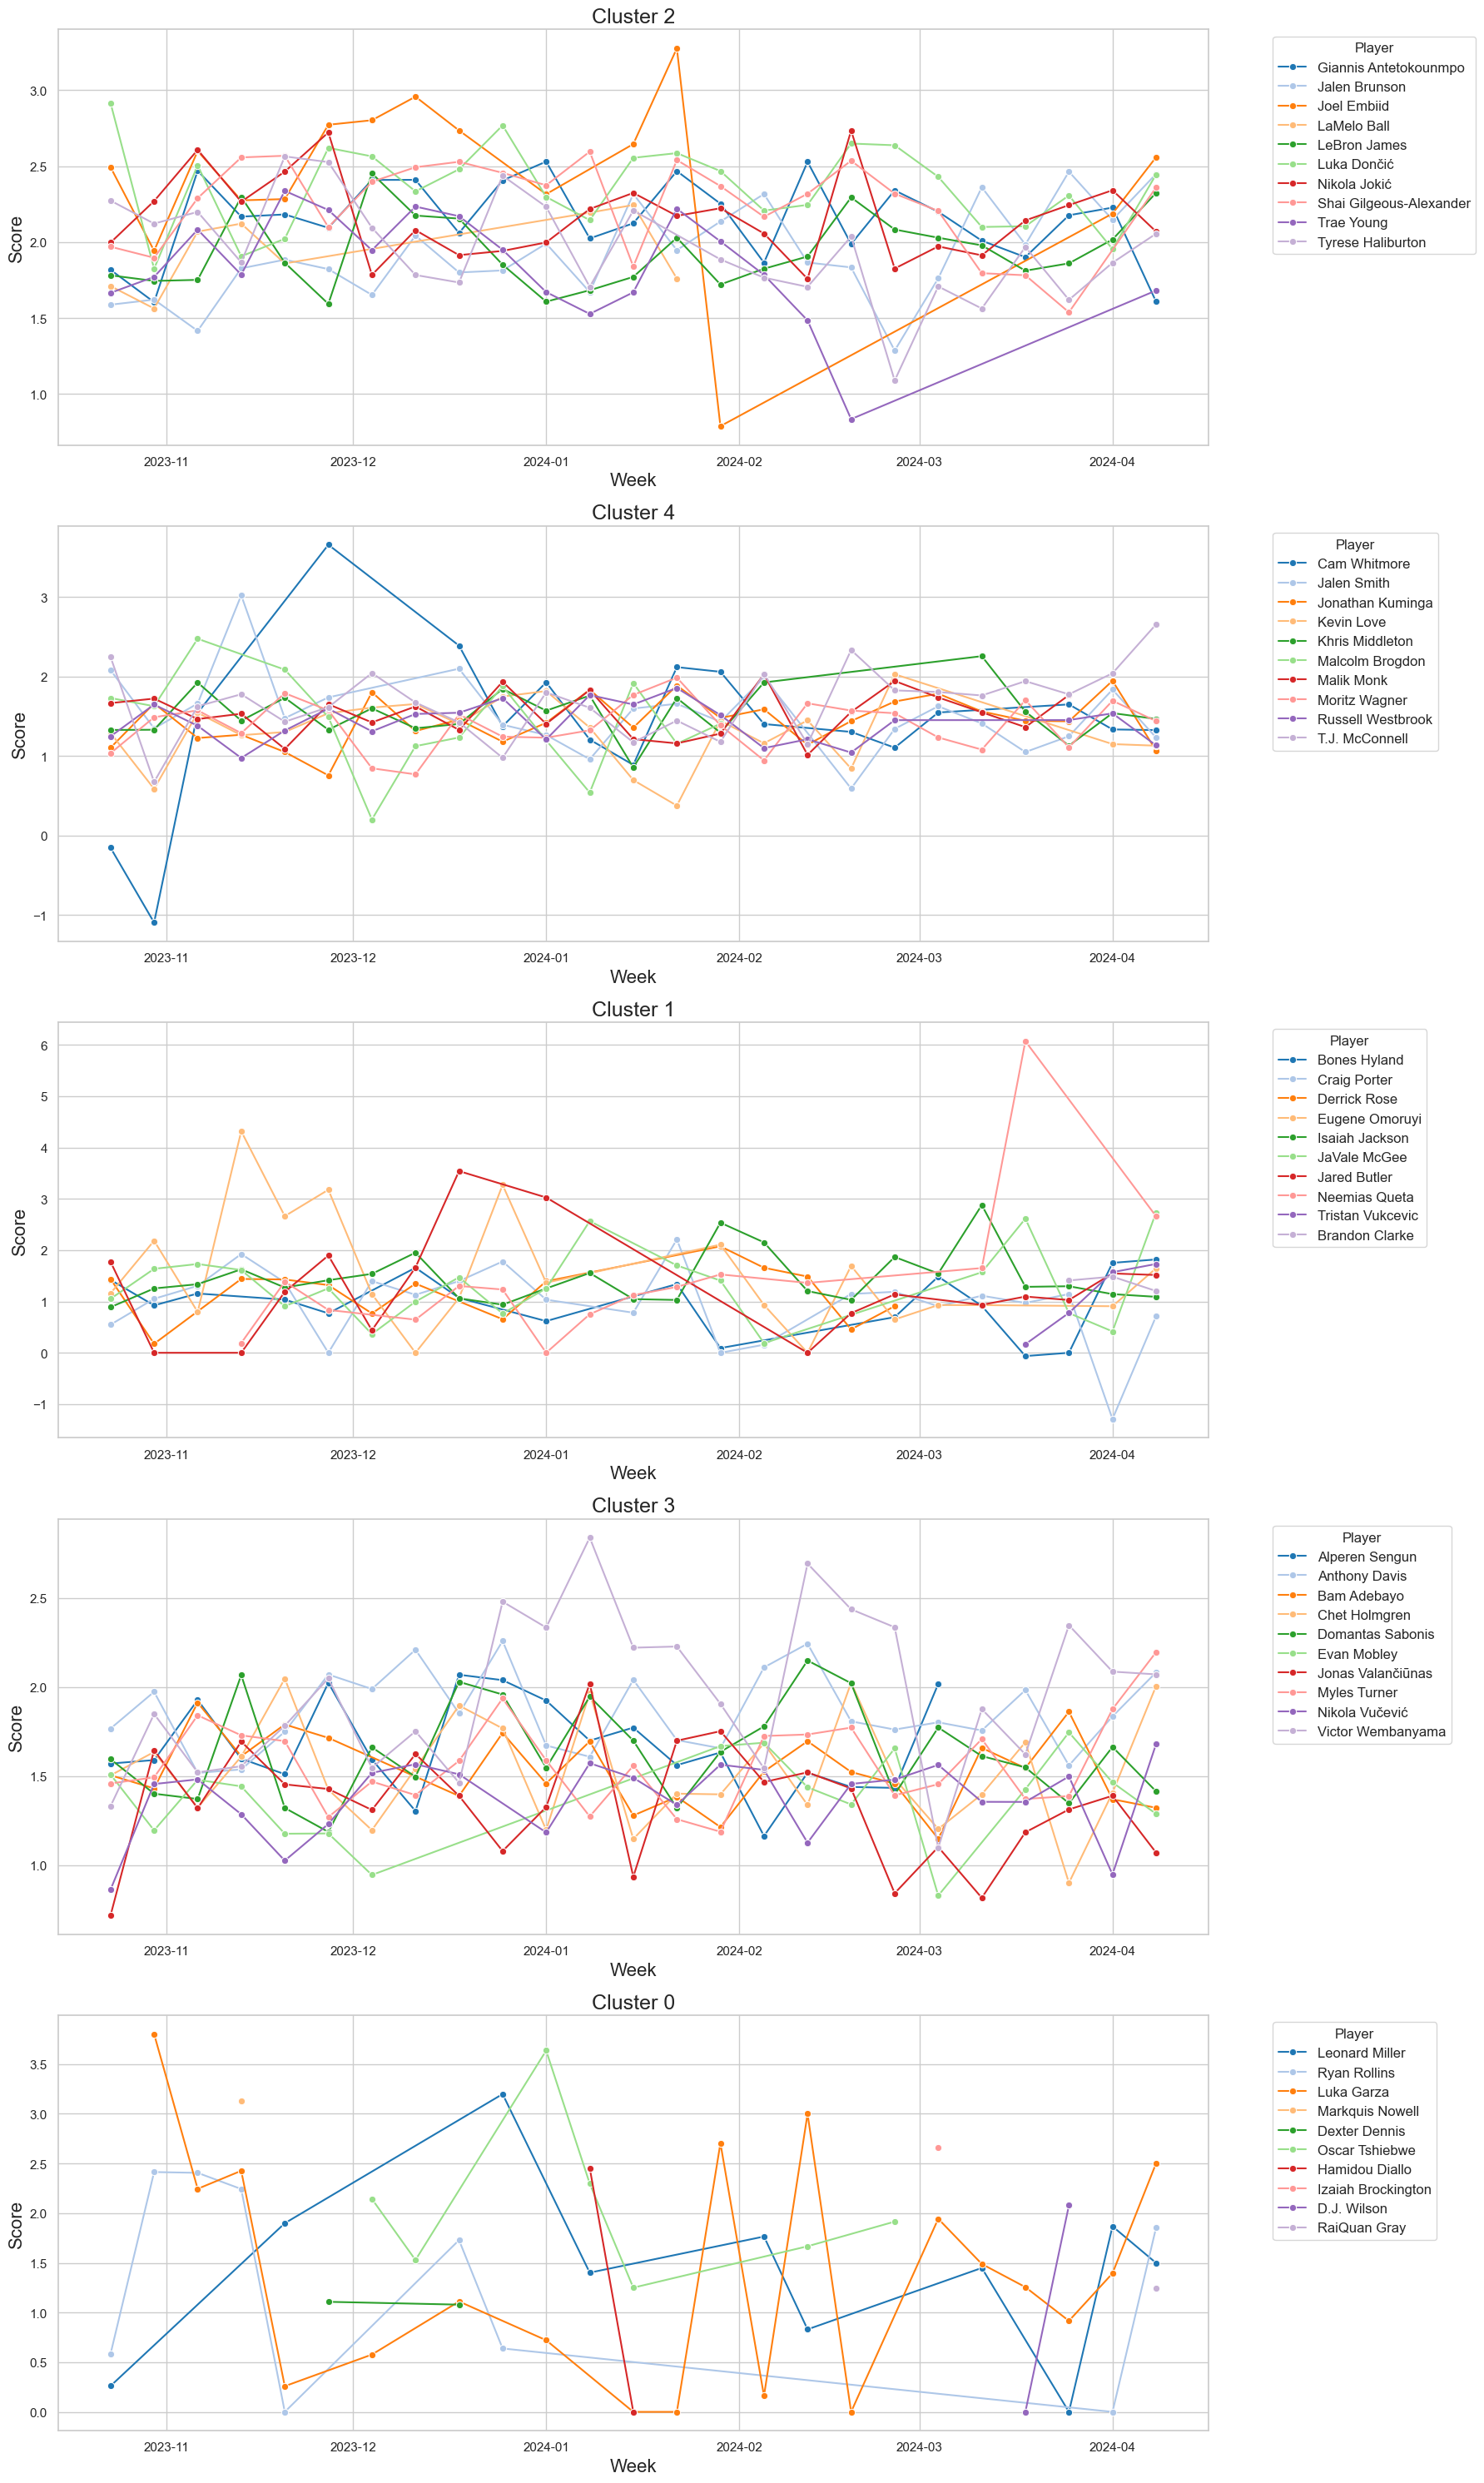

In [46]:
# Merge dos dataframes
merged_df_total = df_total.merge(df[['Player', 'Cluster']], on='Player', how='left')

# Lista de jogadores
players_in_clusters = list(top_players_per_cluster['Player'])

# Filtrar os jogadores selecionados
df_filtered = merged_df_total[merged_df_total['Player'].isin(players_in_clusters)].copy()

# Calcular o Score
df_filtered['Score'] = (
    2 * df_filtered['PTS'] +
    2 * df_filtered['AST'] +
    0.5 * df_filtered['TRB'] +
    2 * df_filtered['BLK'] +
    2 * df_filtered['STL'] -
    2 * df_filtered['TOV']
)/df_filtered['MP']

df_filtered['Date'] = pd.to_datetime(df_filtered['Date'], errors='coerce')

# Agrupar por semana (usando o número da semana e o ano)
df_filtered['Week'] = df_filtered['Date'].dt.to_period('W').dt.start_time  

# Definir o número de clusters
clusters = df_filtered['Cluster'].unique()
num_clusters = len(clusters)

# Ajustar para 1 gráfico por linha
ncols = 1  # Uma coluna por linha
nrows = num_clusters  # Cada cluster tem a su própria linha

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 6 * nrows))  

# Ajustar a disposição das axes
if nrows == 1:
    axes = [axes]  

palette = sns.color_palette("tab20", n_colors=len(players_in_clusters))  

# Plotar um gráfico de linha com pontos para cada cluster
for i, cluster in enumerate(clusters):
    ax = axes[i]
    cluster_data = df_filtered[df_filtered['Cluster'] == cluster]

    # Agrupar por semana e calcular a média do Score
    weekly_data = cluster_data.groupby(['Week', 'Player'], as_index=False)['Score'].mean()

    sns.lineplot(
        x='Week', y='Score', hue='Player', data=weekly_data,
        ax=ax, palette=palette, marker='o'  
    )

    ax.set_title(f'Cluster {cluster}', fontsize=18)
    ax.set_xlabel('Week', fontsize=16)
    ax.set_ylabel('Score', fontsize=16)
    ax.legend(title='Player', fontsize=12, loc='upper left', bbox_to_anchor=(1.05, 1))

# Ajustar o layout
plt.tight_layout()
plt.show()